## Import Libraries

In [56]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
from torch.utils import data
import numpy as np
import matplotlib.pyplot as plt
import math

import glob
import os.path
from model import DDSP
import descriptors
import scipy.io.wavfile as wavfile
import librosa as li
import librosa.display as display
import IPython.display as ipd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [14]:
def listdirectory(path): 
    fichier=[] 
    l = glob.glob(path+'/*') 
    for i in l: 
        if os.path.isdir(i): fichier.extend(listdirectory(i)) 
        else: fichier.append(i) 
    return fichier

## Load model

In [54]:
# Init model parameters
sampling_rate = 16000
block_size = 64
hidden_size = 512
n_harmonics = 50
n_bands = 20
n_layers = 3

model = DDSP(hidden_size, n_harmonics, n_bands, n_layers, sampling_rate, block_size)
checkpoint = torch.load('./results/model_gru.pth', map_location=device)
model.load_state_dict(checkpoint)

<All keys matched successfully>

## Test model on examples

In [28]:
# Import test audio
path = 'test_data'
files = listdirectory(path)
nb_files = len(files)
file = files[0]
sample_per_sec = 250

# Extract pitch and loudness from test audio
sr, y = wavfile.read(file)
y = y[:,0] + y[:,1] / 2
y = li.resample(y, sr, 16000)
y = y.astype(np.float32)
env = np.zeros([2,long*sample_per_sec])
env[0,:] = descriptors.extract_loudness(y, sampling_rate=Fe, block_size=int(Fe/250), n_fft=2048)[:long*sample_per_sec]
env[1,:] = descriptors.extract_pitch(y, sampling_rate=Fe, block_size=int(Fe/250))[:long*sample_per_sec]

<ipython-input-28-2765634ffbc6>:10: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, y = wavfile.read(file)
/usr/local/lib/python3.8/dist-packages/librosa/core/convert.py:1350: RuntimeWarning: divide by zero encountered in log10
  + 2 * np.log10(f_sq)


In [32]:
# Play original audio
ex_audio = y
ipd.Audio(ex_audio, rate=16000)

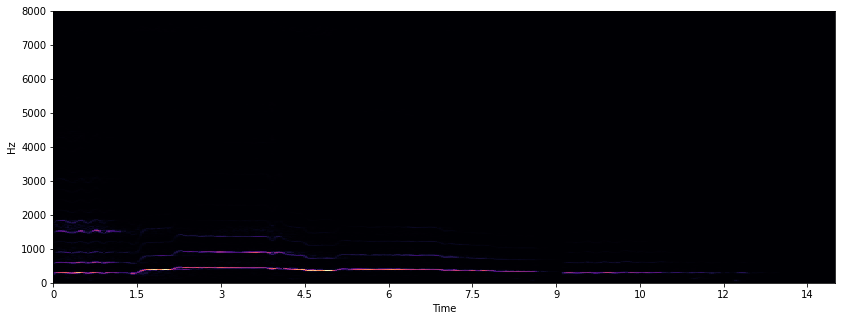

In [40]:
# Compute spectrogram from original audio
Y = abs(li.stft(ex_audio, 1024))
plt.figure(figsize=(14, 5))
display.specshow(Y, sr=16000, x_axis='time', y_axis='hz')

In [49]:
np.shape(env[0,:])

(750,)

In [60]:
# Synthesize audio from pitch and loudness
loudness = torch.tensor(env[0,:]).float().unsqueeze(-1)
loudness = loudness[np.newaxis, :, :]
f0 = torch.tensor(env[1,:]).float().unsqueeze(-1)
f0 = f0[np.newaxis, :, :]
x = model(f0, loudness)

# Play audio
ex_synth = x[0,...].cpu().detach().numpy()
ipd.Audio(ex_synth, rate=16000)

#wavfile.write("example.wav", sampling_rate, ex_synth)

/home/chapa/.local/lib/python3.8/site-packages/torch/functional.py:515: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore


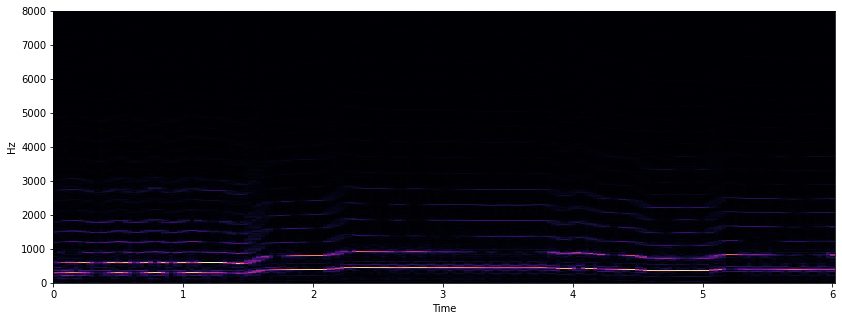

In [61]:
# Compute spectrogram from synthesized audio
X = abs(torch.stft(x, 1024, return_complex = True))
plt.figure(figsize=(14, 5))
display.specshow(X[0,...].cpu().detach().numpy(), sr=16000, x_axis='time', y_axis='hz')